In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=9855b3cd4cad478bfaf222d3f7def43cfc1b39633f92013a6cc55bd1cc05ddf0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9b859d5184b2cdd94f96370bb9e401669b7baad511759aab471321942682fa26
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import os
import gc 
import cv2
import random

from tqdm.auto import tqdm
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from segmentation_models_pytorch.losses import DiceLoss

In [3]:
# def seed_everything(seed=100):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
# seed_everything()

In [4]:
# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 300
LR = 1e-4    
IMG_SIZE = 192
BATCH_SIZE = 16

In [5]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/Train")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/train_labels")
train_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/Train",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/train_labels",x),masks)})
print(train_df.shape)
del images, masks
train_df.head()

(126, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...


In [6]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val_labels")
val_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val_labels",x),masks)})
print(val_df.shape)
del images, masks
val_df.head()

(40, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...


In [7]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test_labels")
test_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test_labels",x),masks)})
print(test_df.shape)
del images, masks
test_df.head()

(40, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...


In [8]:
def encode_labels(masks):
    labelencoder = LabelEncoder()
    masks_reshaped = masks.reshape(-1)
    masks_encoded = labelencoder.fit_transform(masks_reshaped)
    del masks_reshaped, labelencoder
    return masks_encoded.reshape(masks.shape)

In [9]:
# Create a custom dataset class
classes=9
class SegmentationDataset(Dataset):
    def __init__(self, df):
        self.df = df
        images=[]
        masks=[]
        for idx in range(len(self.df)):
            sample = self.df.iloc[idx]
            images.append(load_img(sample.images, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE)))
            masks.append(load_img(sample.masks, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE)))
        images = np.array(images)
        masks = np.array(masks)
        n_classes = classes #len(np.unique(masks))
        masks_encoded = encode_labels(masks)
        self.masks_cat = to_categorical(masks_encoded, num_classes=n_classes)
        self.images = np.expand_dims(images, axis=-1) / 255.0
        del masks_encoded, images, masks, n_classes
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = torch.from_numpy(np.transpose(self.images[idx],(2, 0, 1))).float()
        mask = torch.from_numpy(np.transpose(self.masks_cat[idx],(2, 0, 1))).float()
        return image, mask

In [10]:
# Processed train and validation sets
train_data = SegmentationDataset(train_df)
val_data = SegmentationDataset(val_df)
test_data = SegmentationDataset(test_df)

In [11]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 126
Size of Validset : 40


In [12]:
from torch.utils.data import DataLoader

In [13]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_data, batch_size=1, shuffle=False)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 8
Total number of batches in Val Loader: 3


In [14]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([16, 1, 192, 192])
Size of one batch of masks: torch.Size([16, 9, 192, 192])


In [15]:
dice_loss = DiceLoss(mode="multilabel", classes=9)

def dice_score(y_true, y_pred):
    return 1.0-dice_loss(y_true, y_pred)

In [19]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [44]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [23]:
model = UNet(n_channels=1, n_classes=classes)
model.to(DEVICE);

In [24]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    total_score = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits = model(images)
        
        loss = dice_loss(logits, masks)
        score = dice_score(logits, masks)
        
        loss.backward()
        optimizer.step()
        total_score += score.item()
        total_loss += loss.item()

    return total_loss / len(data_loader), total_score / len(data_loader)

In [25]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    total_score = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            logits = model(images)
        
            loss = dice_loss(logits, masks)
            score = dice_score(logits, masks)

            total_score += score.item()
            total_loss += loss.item()

        return total_loss / len(data_loader), total_score / len(data_loader)

In [26]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

In [27]:
gc.collect()

278

In [28]:
# Training and evaluation loop
best_val_loss = 1e9
writer=SummaryWriter("DiceLoss_Clean_Dataset")
for i in range(EPOCHS):
    train_loss, train_score = train_model(trainloader, model, optimizer)
    val_loss, val_score = eval_model(valloader, model)

    if val_loss < best_val_loss:
        print("MODEL SAVED")
        
        best_val_loss = val_loss
    writer.add_scalar("Loss/train", train_loss, i)
    writer.add_scalar("Loss/val", val_loss, i)
    writer.add_scalar("Score/train", train_score, i)
    writer.add_scalar("Score/val", val_score, i)
    writer.flush()
    print(f"\033[1m\033[92m Epoch {i} Train DiceLoss {train_loss} Val DiceLoss {val_loss} Train dice_score {train_score} Val dice_score {val_score}")
writer.close()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 0 Train DiceLoss 0.8665927723050117 Val DiceLoss 0.8923839728037516 Train dice_score 0.13340722769498825 Val dice_score 0.10761602719624837


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 1 Train DiceLoss 0.8504175618290901 Val DiceLoss 0.8896531263987223 Train dice_score 0.14958243817090988 Val dice_score 0.11034687360127766


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 2 Train DiceLoss 0.8461169674992561 Val DiceLoss 0.8836143215497335 Train dice_score 0.15388303250074387 Val dice_score 0.11638567845026652


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 3 Train DiceLoss 0.8430687859654427 Val DiceLoss 0.8767874240875244 Train dice_score 0.15693121403455734 Val dice_score 0.12321257591247559


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 4 Train DiceLoss 0.8408774808049202 Val DiceLoss 0.8686056534449259 Train dice_score 0.1591225191950798 Val dice_score 0.13139434655507407


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 5 Train DiceLoss 0.838737241923809 Val DiceLoss 0.8582000732421875 Train dice_score 0.16126275807619095 Val dice_score 0.1417999267578125


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 6 Train DiceLoss 0.8368880897760391 Val DiceLoss 0.8458096186319987 Train dice_score 0.16311191022396088 Val dice_score 0.1541903813680013


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 7 Train DiceLoss 0.8351241499185562 Val DiceLoss 0.8328510125478109 Train dice_score 0.1648758500814438 Val dice_score 0.16714898745218912


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 8 Train DiceLoss 0.8343398496508598 Val DiceLoss 0.8296265800793966 Train dice_score 0.16566015034914017 Val dice_score 0.17037341992060342


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 9 Train DiceLoss 0.8318518176674843 Val DiceLoss 0.8301437099774679 Train dice_score 0.16814818233251572 Val dice_score 0.16985629002253214


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 10 Train DiceLoss 0.8303500115871429 Val DiceLoss 0.8279450535774231 Train dice_score 0.16964998841285706 Val dice_score 0.1720549464225769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 11 Train DiceLoss 0.8286944776773453 Val DiceLoss 0.8255297144254049 Train dice_score 0.17130552232265472 Val dice_score 0.17447028557459512


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 12 Train DiceLoss 0.8271857872605324 Val DiceLoss 0.8236810763676962 Train dice_score 0.17281421273946762 Val dice_score 0.17631892363230386


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 13 Train DiceLoss 0.8256238922476768 Val DiceLoss 0.8216066956520081 Train dice_score 0.17437610775232315 Val dice_score 0.17839330434799194


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 14 Train DiceLoss 0.8242105022072792 Val DiceLoss 0.819220761458079 Train dice_score 0.1757894977927208 Val dice_score 0.180779238541921


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 15 Train DiceLoss 0.8225756734609604 Val DiceLoss 0.8175164063771566 Train dice_score 0.1774243265390396 Val dice_score 0.18248359362284342


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 16 Train DiceLoss 0.8209604173898697 Val DiceLoss 0.8157464265823364 Train dice_score 0.1790395826101303 Val dice_score 0.18425357341766357


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 17 Train DiceLoss 0.8194494768977165 Val DiceLoss 0.8153264323870341 Train dice_score 0.18055052310228348 Val dice_score 0.1846735676129659


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 18 Train DiceLoss 0.8179255425930023 Val DiceLoss 0.8123805522918701 Train dice_score 0.18207445740699768 Val dice_score 0.18761944770812988


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 19 Train DiceLoss 0.8165055215358734 Val DiceLoss 0.8115420738855997 Train dice_score 0.1834944784641266 Val dice_score 0.18845792611440024


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 20 Train DiceLoss 0.814795546233654 Val DiceLoss 0.8087747494379679 Train dice_score 0.18520445376634598 Val dice_score 0.19122525056203207


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 21 Train DiceLoss 0.8134487122297287 Val DiceLoss 0.8075729608535767 Train dice_score 0.1865512877702713 Val dice_score 0.19242703914642334


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 22 Train DiceLoss 0.8117416054010391 Val DiceLoss 0.8060224056243896 Train dice_score 0.18825839459896088 Val dice_score 0.19397759437561035


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 23 Train DiceLoss 0.810150533914566 Val DiceLoss 0.8040730754534403 Train dice_score 0.18984946608543396 Val dice_score 0.19592692454655966


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 24 Train DiceLoss 0.8086536154150963 Val DiceLoss 0.8028377294540405 Train dice_score 0.19134638458490372 Val dice_score 0.19716227054595947


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 25 Train DiceLoss 0.8069526106119156 Val DiceLoss 0.8005437850952148 Train dice_score 0.1930473893880844 Val dice_score 0.19945621490478516


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 26 Train DiceLoss 0.805314689874649 Val DiceLoss 0.7998521129290262 Train dice_score 0.19468531012535095 Val dice_score 0.20014788707097372


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 27 Train DiceLoss 0.8037943169474602 Val DiceLoss 0.7977252205212911 Train dice_score 0.19620568305253983 Val dice_score 0.2022747794787089


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 28 Train DiceLoss 0.8021041825413704 Val DiceLoss 0.7968325018882751 Train dice_score 0.1978958174586296 Val dice_score 0.20316749811172485


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 29 Train DiceLoss 0.8003560602664948 Val DiceLoss 0.7950513362884521 Train dice_score 0.19964393973350525 Val dice_score 0.20494866371154785


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 30 Train DiceLoss 0.7986618876457214 Val DiceLoss 0.7922582030296326 Train dice_score 0.20133811235427856 Val dice_score 0.20774179697036743


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 31 Train DiceLoss 0.7970150634646416 Val DiceLoss 0.7889793713887533 Train dice_score 0.20298493653535843 Val dice_score 0.21102062861124674


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 32 Train DiceLoss 0.7950069904327393 Val DiceLoss 0.7884992361068726 Train dice_score 0.20499300956726074 Val dice_score 0.21150076389312744


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 33 Train DiceLoss 0.7930575460195541 Val DiceLoss 0.7869388659795126 Train dice_score 0.20694245398044586 Val dice_score 0.21306113402048746


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 34 Train DiceLoss 0.7912706583738327 Val DiceLoss 0.7861055731773376 Train dice_score 0.2087293416261673 Val dice_score 0.21389442682266235


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 35 Train DiceLoss 0.7893111556768417 Val DiceLoss 0.783596396446228 Train dice_score 0.21068884432315826 Val dice_score 0.21640360355377197


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 36 Train DiceLoss 0.7872286140918732 Val DiceLoss 0.7802956501642863 Train dice_score 0.21277138590812683 Val dice_score 0.2197043498357137


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 37 Train DiceLoss 0.7848325222730637 Val DiceLoss 0.7756087779998779 Train dice_score 0.21516747772693634 Val dice_score 0.22439122200012207


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 38 Train DiceLoss 0.7827115133404732 Val DiceLoss 0.7754795948664347 Train dice_score 0.21728848665952682 Val dice_score 0.22452040513356528


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 39 Train DiceLoss 0.7804790288209915 Val DiceLoss 0.7734113136927286 Train dice_score 0.21952097117900848 Val dice_score 0.22658868630727133


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 40 Train DiceLoss 0.7784532383084297 Val DiceLoss 0.7721134026845297 Train dice_score 0.22154676169157028 Val dice_score 0.22788659731547037


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 41 Train DiceLoss 0.775995597243309 Val DiceLoss 0.7684828042984009 Train dice_score 0.22400440275669098 Val dice_score 0.23151719570159912


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 42 Train DiceLoss 0.7737221047282219 Val DiceLoss 0.7647908131281534 Train dice_score 0.2262778952717781 Val dice_score 0.23520918687184653


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 43 Train DiceLoss 0.7713454961776733 Val DiceLoss 0.7634680271148682 Train dice_score 0.22865450382232666 Val dice_score 0.23653197288513184


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 44 Train DiceLoss 0.7694696635007858 Val DiceLoss 0.7584906220436096 Train dice_score 0.23053033649921417 Val dice_score 0.24150937795639038


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 45 Train DiceLoss 0.766498252749443 Val DiceLoss 0.7590366800626119 Train dice_score 0.23350174725055695 Val dice_score 0.2409633199373881


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 46 Train DiceLoss 0.7640744149684906 Val DiceLoss 0.7530020078023275 Train dice_score 0.2359255850315094 Val dice_score 0.24699799219767252


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 47 Train DiceLoss 0.7616162747144699 Val DiceLoss 0.751436710357666 Train dice_score 0.2383837252855301 Val dice_score 0.24856328964233398


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 48 Train DiceLoss 0.7591126039624214 Val DiceLoss 0.750319262345632 Train dice_score 0.24088739603757858 Val dice_score 0.24968073765436807


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 49 Train DiceLoss 0.7564142793416977 Val DiceLoss 0.7453531424204508 Train dice_score 0.2435857206583023 Val dice_score 0.25464685757954914


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 50 Train DiceLoss 0.7537805140018463 Val DiceLoss 0.7463675936063131 Train dice_score 0.2462194859981537 Val dice_score 0.25363240639368695


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 51 Train DiceLoss 0.7511660978198051 Val DiceLoss 0.7427056233088175 Train dice_score 0.24883390218019485 Val dice_score 0.25729437669118244


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 52 Train DiceLoss 0.7484692558646202 Val DiceLoss 0.7389456828435262 Train dice_score 0.2515307441353798 Val dice_score 0.2610543171564738


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 53 Train DiceLoss 0.7456782981753349 Val DiceLoss 0.7348196506500244 Train dice_score 0.25432170182466507 Val dice_score 0.2651803493499756


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 54 Train DiceLoss 0.7427449971437454 Val DiceLoss 0.7362256844838461 Train dice_score 0.2572550028562546 Val dice_score 0.263774315516154


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 55 Train DiceLoss 0.740325078368187 Val DiceLoss 0.7387389540672302 Train dice_score 0.25967492163181305 Val dice_score 0.2612610459327698


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 56 Train DiceLoss 0.7413420528173447 Val DiceLoss 0.7547247608502706 Train dice_score 0.25865794718265533 Val dice_score 0.2452752391497294


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 57 Train DiceLoss 0.7345714643597603 Val DiceLoss 0.7253007094065348 Train dice_score 0.2654285356402397 Val dice_score 0.27469929059346515


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 58 Train DiceLoss 0.7312589436769485 Val DiceLoss 0.7183014551798502 Train dice_score 0.26874105632305145 Val dice_score 0.2816985448201497


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 59 Train DiceLoss 0.7280392497777939 Val DiceLoss 0.7143058578173319 Train dice_score 0.2719607502222061 Val dice_score 0.28569414218266803


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 60 Train DiceLoss 0.7249245494604111 Val DiceLoss 0.7114660143852234 Train dice_score 0.27507545053958893 Val dice_score 0.2885339856147766


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 61 Train DiceLoss 0.7217265665531158 Val DiceLoss 0.7087119817733765 Train dice_score 0.27827343344688416 Val dice_score 0.29128801822662354


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 62 Train DiceLoss 0.718545638024807 Val DiceLoss 0.702537477016449 Train dice_score 0.281454361975193 Val dice_score 0.297462522983551


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 63 Train DiceLoss 0.7151831090450287 Val DiceLoss 0.7018283406893412 Train dice_score 0.2848168909549713 Val dice_score 0.29817165931065875


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 64 Train DiceLoss 0.7119087651371956 Val DiceLoss 0.6969735821088155 Train dice_score 0.2880912348628044 Val dice_score 0.3030264178911845


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 65 Train DiceLoss 0.70878866314888 Val DiceLoss 0.694093922773997 Train dice_score 0.29121133685112 Val dice_score 0.305906077226003


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 66 Train DiceLoss 0.7051623314619064 Val DiceLoss 0.6925292412439982 Train dice_score 0.29483766853809357 Val dice_score 0.30747075875600177


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 67 Train DiceLoss 0.7017990574240685 Val DiceLoss 0.6875921686490377 Train dice_score 0.29820094257593155 Val dice_score 0.31240783135096234


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 68 Train DiceLoss 0.6982308179140091 Val DiceLoss 0.6860988140106201 Train dice_score 0.3017691820859909 Val dice_score 0.3139011859893799


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 69 Train DiceLoss 0.6951011344790459 Val DiceLoss 0.6806748906771342 Train dice_score 0.30489886552095413 Val dice_score 0.3193251093228658


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 70 Train DiceLoss 0.6915044486522675 Val DiceLoss 0.6743336121241251 Train dice_score 0.30849555134773254 Val dice_score 0.3256663878758748


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 71 Train DiceLoss 0.6876889765262604 Val DiceLoss 0.6741022864977518 Train dice_score 0.3123110234737396 Val dice_score 0.3258977135022481


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 72 Train DiceLoss 0.6846029534935951 Val DiceLoss 0.6678634683291117 Train dice_score 0.3153970465064049 Val dice_score 0.33213653167088825


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 73 Train DiceLoss 0.6803093031048775 Val DiceLoss 0.6646742423375448 Train dice_score 0.31969069689512253 Val dice_score 0.33532575766245526


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 74 Train DiceLoss 0.6763723567128181 Val DiceLoss 0.6630537708600363 Train dice_score 0.32362764328718185 Val dice_score 0.3369462291399638


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 75 Train DiceLoss 0.6730660647153854 Val DiceLoss 0.6637066801389059 Train dice_score 0.32693393528461456 Val dice_score 0.3362933198610942


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 76 Train DiceLoss 0.6689972132444382 Val DiceLoss 0.6498518188794454 Train dice_score 0.33100278675556183 Val dice_score 0.3501481811205546


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 77 Train DiceLoss 0.6650499701499939 Val DiceLoss 0.6464824279149374 Train dice_score 0.3349500298500061 Val dice_score 0.3535175720850627


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 78 Train DiceLoss 0.6610637903213501 Val DiceLoss 0.6409233808517456 Train dice_score 0.3389362096786499 Val dice_score 0.3590766191482544


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 79 Train DiceLoss 0.657235324382782 Val DiceLoss 0.6454444726308187 Train dice_score 0.342764675617218 Val dice_score 0.35455552736918133


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 80 Train DiceLoss 0.6532935351133347 Val DiceLoss 0.6341203451156616 Train dice_score 0.34670646488666534 Val dice_score 0.3658796548843384


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 81 Train DiceLoss 0.6489224061369896 Val DiceLoss 0.6299897233645121 Train dice_score 0.3510775938630104 Val dice_score 0.37001027663548786


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 82 Train DiceLoss 0.6443690955638885 Val DiceLoss 0.6219243804613749 Train dice_score 0.35563090443611145 Val dice_score 0.37807561953862506


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 83 Train DiceLoss 0.6398624330759048 Val DiceLoss 0.6257902383804321 Train dice_score 0.36013756692409515 Val dice_score 0.37420976161956787


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 84 Train DiceLoss 0.6358850672841072 Val DiceLoss 0.6162634293238322 Train dice_score 0.3641149327158928 Val dice_score 0.3837365706761678


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 85 Train DiceLoss 0.631992518901825 Val DiceLoss 0.6075588464736938 Train dice_score 0.36800748109817505 Val dice_score 0.39244115352630615


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 86 Train DiceLoss 0.6266803592443466 Val DiceLoss 0.6133045355478922 Train dice_score 0.3733196407556534 Val dice_score 0.38669546445210773


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 87 Train DiceLoss 0.6229935958981514 Val DiceLoss 0.6010785897572836 Train dice_score 0.3770064041018486 Val dice_score 0.3989214102427165


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 88 Train DiceLoss 0.6181357204914093 Val DiceLoss 0.5939619739850363 Train dice_score 0.3818642795085907 Val dice_score 0.4060380260149638


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 89 Train DiceLoss 0.6136033684015274 Val DiceLoss 0.6006024877230326 Train dice_score 0.3863966315984726 Val dice_score 0.39939751227696735


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 90 Train DiceLoss 0.609665647149086 Val DiceLoss 0.5841529766718546 Train dice_score 0.390334352850914 Val dice_score 0.4158470233281453


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 91 Train DiceLoss 0.6050144955515862 Val DiceLoss 0.5905866821606954 Train dice_score 0.39498550444841385 Val dice_score 0.4094133178393046


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 92 Train DiceLoss 0.6000482216477394 Val DiceLoss 0.578070859114329 Train dice_score 0.3999517783522606 Val dice_score 0.42192914088567096


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 93 Train DiceLoss 0.5963645502924919 Val DiceLoss 0.5639931956926981 Train dice_score 0.4036354497075081 Val dice_score 0.4360068043073018


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 94 Train DiceLoss 0.5912431851029396 Val DiceLoss 0.5590699315071106 Train dice_score 0.4087568148970604 Val dice_score 0.4409300684928894


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 95 Train DiceLoss 0.5865020304918289 Val DiceLoss 0.547632118066152 Train dice_score 0.4134979695081711 Val dice_score 0.4523678819338481


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 96 Train DiceLoss 0.5818857327103615 Val DiceLoss 0.5482014417648315 Train dice_score 0.4181142672896385 Val dice_score 0.45179855823516846


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 97 Train DiceLoss 0.5774573460221291 Val DiceLoss 0.5407701532046 Train dice_score 0.42254265397787094 Val dice_score 0.45922984679539997


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 98 Train DiceLoss 0.5726548135280609 Val DiceLoss 0.5393172899881998 Train dice_score 0.4273451864719391 Val dice_score 0.4606827100118001


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 99 Train DiceLoss 0.5680417194962502 Val DiceLoss 0.527332623799642 Train dice_score 0.43195828050374985 Val dice_score 0.4726673762003581


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 100 Train DiceLoss 0.5626858621835709 Val DiceLoss 0.5277610222498575 Train dice_score 0.43731413781642914 Val dice_score 0.4722389777501424


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 101 Train DiceLoss 0.5583312213420868 Val DiceLoss 0.5254968404769897 Train dice_score 0.4416687786579132 Val dice_score 0.47450315952301025


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 102 Train DiceLoss 0.5538204908370972 Val DiceLoss 0.5142694115638733 Train dice_score 0.44617950916290283 Val dice_score 0.4857305884361267


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 103 Train DiceLoss 0.5493306890130043 Val DiceLoss 0.5051445563634237 Train dice_score 0.4506693109869957 Val dice_score 0.49485544363657635


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 104 Train DiceLoss 0.5450818166136742 Val DiceLoss 0.5139735738436381 Train dice_score 0.45491818338632584 Val dice_score 0.4860264261563619


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 105 Train DiceLoss 0.5397179946303368 Val DiceLoss 0.4981571634610494 Train dice_score 0.46028200536966324 Val dice_score 0.5018428166707357


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 106 Train DiceLoss 0.5358694419264793 Val DiceLoss 0.4948052962621053 Train dice_score 0.46413055807352066 Val dice_score 0.5051947037378947


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 107 Train DiceLoss 0.530995100736618 Val DiceLoss 0.4932742516199748 Train dice_score 0.46900489926338196 Val dice_score 0.5067257483800253


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 108 Train DiceLoss 0.525941289961338 Val DiceLoss 0.48185067375500995 Train dice_score 0.47405871003866196 Val dice_score 0.5181493361790975


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 109 Train DiceLoss 0.5208945944905281 Val DiceLoss 0.4825500249862671 Train dice_score 0.4791054055094719 Val dice_score 0.5174499948819479


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 110 Train DiceLoss 0.5172018483281136 Val DiceLoss 0.4716103176275889 Train dice_score 0.48279815167188644 Val dice_score 0.5283896724383036


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 111 Train DiceLoss 0.5117736458778381 Val DiceLoss 0.4865172207355499 Train dice_score 0.48822635412216187 Val dice_score 0.5134827693303426


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 112 Train DiceLoss 0.507498487830162 Val DiceLoss 0.4579598108927409 Train dice_score 0.49250151216983795 Val dice_score 0.542040208975474


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 113 Train DiceLoss 0.5028036311268806 Val DiceLoss 0.45472081502278644 Train dice_score 0.49719636887311935 Val dice_score 0.5452791849772135


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 114 Train DiceLoss 0.4978650100529194 Val DiceLoss 0.4710073471069336 Train dice_score 0.5021349787712097 Val dice_score 0.5289926330248514


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 115 Train DiceLoss 0.4930597320199013 Val DiceLoss 0.44731659690539044 Train dice_score 0.5069402605295181 Val dice_score 0.552683413028717


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 116 Train DiceLoss 0.4889087453484535 Val DiceLoss 0.4568284551302592 Train dice_score 0.5110912546515465 Val dice_score 0.5431715448697408


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 117 Train DiceLoss 0.48316021263599396 Val DiceLoss 0.43931915362675983 Train dice_score 0.516839787364006 Val dice_score 0.5606808463732401


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 118 Train DiceLoss 0.48012271523475647 Val DiceLoss 0.4237176279226939 Train dice_score 0.5198772773146629 Val dice_score 0.5762823621431986


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 119 Train DiceLoss 0.4742034375667572 Val DiceLoss 0.4244203368822734 Train dice_score 0.5257965698838234 Val dice_score 0.5755796631177267


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 120 Train DiceLoss 0.4684291481971741 Val DiceLoss 0.4357391099135081 Train dice_score 0.5315708592534065 Val dice_score 0.5642609000205994


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 121 Train DiceLoss 0.46458571031689644 Val DiceLoss 0.42189613978068036 Train dice_score 0.5354143008589745 Val dice_score 0.5781038800875345


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 122 Train DiceLoss 0.46011456474661827 Val DiceLoss 0.420769323905309 Train dice_score 0.5398854464292526 Val dice_score 0.5792307058970133


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 123 Train DiceLoss 0.45532965660095215 Val DiceLoss 0.39936232566833496 Train dice_score 0.544670358300209 Val dice_score 0.6006376544634501


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 124 Train DiceLoss 0.45259643718600273 Val DiceLoss 0.39593589305877686 Train dice_score 0.5474035665392876 Val dice_score 0.6040641069412231


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 125 Train DiceLoss 0.44583678990602493 Val DiceLoss 0.39425549904505414 Train dice_score 0.5541632100939751 Val dice_score 0.6057445009549459


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 126 Train DiceLoss 0.4420282803475857 Val DiceLoss 0.3910524845123291 Train dice_score 0.557971715927124 Val dice_score 0.6089475154876709


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 127 Train DiceLoss 0.43642354011535645 Val DiceLoss 0.4052540560563405 Train dice_score 0.5635764673352242 Val dice_score 0.594745953877767


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 128 Train DiceLoss 0.43429770693182945 Val DiceLoss 0.38241999348004657 Train dice_score 0.5657022893428802 Val dice_score 0.6175800164540609


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 129 Train DiceLoss 0.4265853390097618 Val DiceLoss 0.38271579146385193 Train dice_score 0.5734146535396576 Val dice_score 0.6172842184702555


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 130 Train DiceLoss 0.42220594361424446 Val DiceLoss 0.3741130034128825 Train dice_score 0.5777940675616264 Val dice_score 0.6258869965871176


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 131 Train DiceLoss 0.41936591640114784 Val DiceLoss 0.35899248719215393 Train dice_score 0.5806340724229813 Val dice_score 0.6410075227419535


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 132 Train DiceLoss 0.41437987610697746 Val DiceLoss 0.36030757427215576 Train dice_score 0.5856201276183128 Val dice_score 0.6396924058596293


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 133 Train DiceLoss 0.4096400886774063 Val DiceLoss 0.35883936285972595 Train dice_score 0.5903599038720131 Val dice_score 0.6411606272061666


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 134 Train DiceLoss 0.40286094695329666 Val DiceLoss 0.36597691973050434 Train dice_score 0.5971390679478645 Val dice_score 0.6340230902036031


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 135 Train DiceLoss 0.4007103145122528 Val DiceLoss 0.35887916882832843 Train dice_score 0.5992897003889084 Val dice_score 0.6411208311716715


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 136 Train DiceLoss 0.39484910294413567 Val DiceLoss 0.3552419642607371 Train dice_score 0.6051508858799934 Val dice_score 0.6447580456733704


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 137 Train DiceLoss 0.39148470386862755 Val DiceLoss 0.3591082493464152 Train dice_score 0.6085153073072433 Val dice_score 0.6408917506535848


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 138 Train DiceLoss 0.38533053174614906 Val DiceLoss 0.3631170690059662 Train dice_score 0.6146694719791412 Val dice_score 0.6368829210599264


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 139 Train DiceLoss 0.3825737535953522 Val DiceLoss 0.346407155195872 Train dice_score 0.6174262464046478 Val dice_score 0.653592844804128


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 140 Train DiceLoss 0.37691739946603775 Val DiceLoss 0.33537667989730835 Train dice_score 0.6230826079845428 Val dice_score 0.6646233399709066


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 141 Train DiceLoss 0.3714820519089699 Val DiceLoss 0.3185654679934184 Train dice_score 0.6285179555416107 Val dice_score 0.6814345320065817


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 142 Train DiceLoss 0.36753764003515244 Val DiceLoss 0.3124879201253255 Train dice_score 0.6324623674154282 Val dice_score 0.6875120798746744


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 143 Train DiceLoss 0.3650229349732399 Val DiceLoss 0.3117724259694417 Train dice_score 0.6349770575761795 Val dice_score 0.6882275938987732


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 144 Train DiceLoss 0.35928773507475853 Val DiceLoss 0.31674936413764954 Train dice_score 0.6407122761011124 Val dice_score 0.683250625928243


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 145 Train DiceLoss 0.3551430478692055 Val DiceLoss 0.32233843207359314 Train dice_score 0.6448569595813751 Val dice_score 0.6776615579922994


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 146 Train DiceLoss 0.3530469983816147 Val DiceLoss 0.31553829709688824 Train dice_score 0.6469530165195465 Val dice_score 0.6844617128372192


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 147 Train DiceLoss 0.34626663848757744 Val DiceLoss 0.30585648616154987 Train dice_score 0.6537333577871323 Val dice_score 0.6941435138384501


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 148 Train DiceLoss 0.342267245054245 Val DiceLoss 0.3162229557832082 Train dice_score 0.6577327623963356 Val dice_score 0.6837770541508993


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 149 Train DiceLoss 0.3383762873709202 Val DiceLoss 0.292564998070399 Train dice_score 0.6616237163543701 Val dice_score 0.7074350118637085


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 150 Train DiceLoss 0.33505212143063545 Val DiceLoss 0.29592729608217877 Train dice_score 0.6649478822946548 Val dice_score 0.7040726741154989


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 151 Train DiceLoss 0.3312077075242996 Val DiceLoss 0.29736318190892536 Train dice_score 0.6687923073768616 Val dice_score 0.7026367982228597


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 152 Train DiceLoss 0.3265199847519398 Val DiceLoss 0.280743549267451 Train dice_score 0.6734800040721893 Val dice_score 0.7192564407984415


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 153 Train DiceLoss 0.3208727166056633 Val DiceLoss 0.2867423991362254 Train dice_score 0.6791272759437561 Val dice_score 0.713257630666097


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 154 Train DiceLoss 0.3173999600112438 Val DiceLoss 0.2785630722840627 Train dice_score 0.6826000437140465 Val dice_score 0.7214369376500448


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 155 Train DiceLoss 0.3150435946881771 Val DiceLoss 0.29369157552719116 Train dice_score 0.6849564015865326 Val dice_score 0.7063084244728088


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 156 Train DiceLoss 0.3132963255047798 Val DiceLoss 0.271899272998174 Train dice_score 0.6867036744952202 Val dice_score 0.7281007369359335


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 157 Train DiceLoss 0.3044918067753315 Val DiceLoss 0.27880672613779706 Train dice_score 0.6955081820487976 Val dice_score 0.721193273862203


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 158 Train DiceLoss 0.3037067875266075 Val DiceLoss 0.28180064757664997 Train dice_score 0.6962932050228119 Val dice_score 0.7181993722915649


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 159 Train DiceLoss 0.2985244542360306 Val DiceLoss 0.26928136746088666 Train dice_score 0.70147555321455 Val dice_score 0.7307186126708984


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 160 Train DiceLoss 0.29308174178004265 Val DiceLoss 0.2691589097181956 Train dice_score 0.7069182693958282 Val dice_score 0.7308411002159119


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 161 Train DiceLoss 0.29162344709038734 Val DiceLoss 0.25648270050684613 Train dice_score 0.7083765417337418 Val dice_score 0.7435173193613688


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 162 Train DiceLoss 0.28706490993499756 Val DiceLoss 0.26593734820683795 Train dice_score 0.712935097515583 Val dice_score 0.734062671661377


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 163 Train DiceLoss 0.282867394387722 Val DiceLoss 0.2519609381755193 Train dice_score 0.7171326130628586 Val dice_score 0.7480390667915344


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 164 Train DiceLoss 0.2812028005719185 Val DiceLoss 0.2625241776307424 Train dice_score 0.7187972068786621 Val dice_score 0.7374758124351501


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 165 Train DiceLoss 0.27666230499744415 Val DiceLoss 0.27243306239446 Train dice_score 0.723337709903717 Val dice_score 0.7275669574737549


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 166 Train DiceLoss 0.2765105180442333 Val DiceLoss 0.2501956472794215 Train dice_score 0.7234894931316376 Val dice_score 0.7498043576876322


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 167 Train DiceLoss 0.2669638395309448 Val DiceLoss 0.24045266211032867 Train dice_score 0.7330361679196358 Val dice_score 0.7595473329226176


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 168 Train DiceLoss 0.26571525260806084 Val DiceLoss 0.26187976201375324 Train dice_score 0.7342847585678101 Val dice_score 0.7381202379862467


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 169 Train DiceLoss 0.26154185086488724 Val DiceLoss 0.24311925967534384 Train dice_score 0.7384581565856934 Val dice_score 0.7568807403246561


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 170 Train DiceLoss 0.25817621871829033 Val DiceLoss 0.24447614451249441 Train dice_score 0.7418237701058388 Val dice_score 0.7555238604545593


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 171 Train DiceLoss 0.2567376680672169 Val DiceLoss 0.24841432770093283 Train dice_score 0.7432623356580734 Val dice_score 0.7515856822331747


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 172 Train DiceLoss 0.2529708184301853 Val DiceLoss 0.23316582043965658 Train dice_score 0.7470291778445244 Val dice_score 0.7668341795603434


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 173 Train DiceLoss 0.24946864508092403 Val DiceLoss 0.21662919720013937 Train dice_score 0.7505313605070114 Val dice_score 0.7833708127339681


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 174 Train DiceLoss 0.2457207702100277 Val DiceLoss 0.23461289703845978 Train dice_score 0.7542792335152626 Val dice_score 0.7653871178627014


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 175 Train DiceLoss 0.24404850788414478 Val DiceLoss 0.22477387885252634 Train dice_score 0.7559514939785004 Val dice_score 0.7752261161804199


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 176 Train DiceLoss 0.23959406279027462 Val DiceLoss 0.23081945379575095 Train dice_score 0.7604059353470802 Val dice_score 0.7691805561383566


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 177 Train DiceLoss 0.23543822951614857 Val DiceLoss 0.21363373597462973 Train dice_score 0.7645617797970772 Val dice_score 0.7863662640253702


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 178 Train DiceLoss 0.23177271150052547 Val DiceLoss 0.20130292077859244 Train dice_score 0.7682272866368294 Val dice_score 0.7986970742543539


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 179 Train DiceLoss 0.2290067132562399 Val DiceLoss 0.19856917361418405 Train dice_score 0.770993284881115 Val dice_score 0.8014308015505472


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 180 Train DiceLoss 0.226704191416502 Val DiceLoss 0.19954902430375418 Train dice_score 0.7732958123087883 Val dice_score 0.8004509806632996


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 181 Train DiceLoss 0.2228093072772026 Val DiceLoss 0.19260489443937936 Train dice_score 0.777190700173378 Val dice_score 0.8073951005935669


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 182 Train DiceLoss 0.22077772580087185 Val DiceLoss 0.19793339570363364 Train dice_score 0.779222272336483 Val dice_score 0.8020666042963663


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 183 Train DiceLoss 0.2225378006696701 Val DiceLoss 0.1852260778347651 Train dice_score 0.7774622067809105 Val dice_score 0.8147739171981812


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 184 Train DiceLoss 0.21584469266235828 Val DiceLoss 0.18202937146027884 Train dice_score 0.7841553092002869 Val dice_score 0.8179706335067749


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 185 Train DiceLoss 0.21212221682071686 Val DiceLoss 0.18847893178462982 Train dice_score 0.787877768278122 Val dice_score 0.811521073182424


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 186 Train DiceLoss 0.20746980980038643 Val DiceLoss 0.18220184246699014 Train dice_score 0.7925301864743233 Val dice_score 0.8177981575330099


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 187 Train DiceLoss 0.2073285412043333 Val DiceLoss 0.1867257903019587 Train dice_score 0.7926714420318604 Val dice_score 0.8132742245992025


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 188 Train DiceLoss 0.20585364289581776 Val DiceLoss 0.1819483290115992 Train dice_score 0.7941463589668274 Val dice_score 0.8180516560872396


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 189 Train DiceLoss 0.20131284557282925 Val DiceLoss 0.18613094091415405 Train dice_score 0.798687145113945 Val dice_score 0.813869039217631


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 190 Train DiceLoss 0.19903103075921535 Val DiceLoss 0.17855593065420786 Train dice_score 0.8009689748287201 Val dice_score 0.8214440743128458


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 191 Train DiceLoss 0.19467856362462044 Val DiceLoss 0.17476341625054678 Train dice_score 0.8053214401006699 Val dice_score 0.8252365986506144


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 192 Train DiceLoss 0.19348474591970444 Val DiceLoss 0.16655785342057547 Train dice_score 0.8065152615308762 Val dice_score 0.8334421515464783


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 193 Train DiceLoss 0.19159099273383617 Val DiceLoss 0.168468177318573 Train dice_score 0.8084090128540993 Val dice_score 0.831531842549642


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 194 Train DiceLoss 0.1859478559345007 Val DiceLoss 0.17455808818340302 Train dice_score 0.8140521347522736 Val dice_score 0.8254418969154358


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 195 Train DiceLoss 0.1876745279878378 Val DiceLoss 0.17493418355782828 Train dice_score 0.8123254850506783 Val dice_score 0.8250658313433329


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 196 Train DiceLoss 0.18513397313654423 Val DiceLoss 0.16580134133497873 Train dice_score 0.8148660361766815 Val dice_score 0.8341986536979675


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 197 Train DiceLoss 0.17975996993482113 Val DiceLoss 0.16600059469540915 Train dice_score 0.8202400282025337 Val dice_score 0.8339993953704834


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 198 Train DiceLoss 0.1762737762182951 Val DiceLoss 0.16415620346864065 Train dice_score 0.8237262293696404 Val dice_score 0.8358437816301981


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 199 Train DiceLoss 0.17355820164084435 Val DiceLoss 0.17026869455973306 Train dice_score 0.826441802084446 Val dice_score 0.829731305440267


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 200 Train DiceLoss 0.17654125206172466 Val DiceLoss 0.15983655055363974 Train dice_score 0.8234587535262108 Val dice_score 0.8401634494463602


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 201 Train DiceLoss 0.17231070436537266 Val DiceLoss 0.1648417462905248 Train dice_score 0.8276893049478531 Val dice_score 0.8351582288742065


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 202 Train DiceLoss 0.16698150523006916 Val DiceLoss 0.15328937768936157 Train dice_score 0.833018496632576 Val dice_score 0.8467106223106384


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 203 Train DiceLoss 0.16777209006249905 Val DiceLoss 0.159545307358106 Train dice_score 0.8322279155254364 Val dice_score 0.8404546777407328


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 204 Train DiceLoss 0.16493955813348293 Val DiceLoss 0.15462676187356314 Train dice_score 0.8350604325532913 Val dice_score 0.8453732331593832


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 205 Train DiceLoss 0.16300812363624573 Val DiceLoss 0.15188662707805634 Train dice_score 0.8369918838143349 Val dice_score 0.8481133778889974


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 206 Train DiceLoss 0.1590385064482689 Val DiceLoss 0.14594367643197378 Train dice_score 0.8409614935517311 Val dice_score 0.8540563186009725


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 207 Train DiceLoss 0.1558092962950468 Val DiceLoss 0.14973844587802887 Train dice_score 0.8441907092928886 Val dice_score 0.8502615690231323


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 208 Train DiceLoss 0.15609311312437057 Val DiceLoss 0.14651099840799967 Train dice_score 0.8439068794250488 Val dice_score 0.8534890015920004


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 209 Train DiceLoss 0.15326142124831676 Val DiceLoss 0.1530648668607076 Train dice_score 0.8467385917901993 Val dice_score 0.8469351331392924


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 210 Train DiceLoss 0.15395146049559116 Val DiceLoss 0.14512859284877777 Train dice_score 0.8460485339164734 Val dice_score 0.854871412118276


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 211 Train DiceLoss 0.15161151997745037 Val DiceLoss 0.14941895504792532 Train dice_score 0.8483884856104851 Val dice_score 0.8505810300509135


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 212 Train DiceLoss 0.1478473637253046 Val DiceLoss 0.14596420526504517 Train dice_score 0.85215263068676 Val dice_score 0.8540357947349548


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 213 Train DiceLoss 0.1447111051529646 Val DiceLoss 0.15446904798348746 Train dice_score 0.8552889004349709 Val dice_score 0.8455309470494589


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 214 Train DiceLoss 0.1425368171185255 Val DiceLoss 0.14135728279749551 Train dice_score 0.8574631810188293 Val dice_score 0.8586427172025045


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 215 Train DiceLoss 0.14343023858964443 Val DiceLoss 0.14888008932272592 Train dice_score 0.856569766998291 Val dice_score 0.8511199156443278


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 216 Train DiceLoss 0.14157972484827042 Val DiceLoss 0.14826984703540802 Train dice_score 0.8584202751517296 Val dice_score 0.8517301479975382


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 217 Train DiceLoss 0.13624748028814793 Val DiceLoss 0.14710106452306113 Train dice_score 0.8637525290250778 Val dice_score 0.8528989354769388


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 218 Train DiceLoss 0.13515806384384632 Val DiceLoss 0.13735623160998026 Train dice_score 0.8648419305682182 Val dice_score 0.8626437584559122


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 219 Train DiceLoss 0.134344931691885 Val DiceLoss 0.13656805952390036 Train dice_score 0.8656550645828247 Val dice_score 0.8634319504102071


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 220 Train DiceLoss 0.13411631993949413 Val DiceLoss 0.14093910654385886 Train dice_score 0.8658836856484413 Val dice_score 0.8590609232584635


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 221 Train DiceLoss 0.13009979203343391 Val DiceLoss 0.1365733196338018 Train dice_score 0.8699002042412758 Val dice_score 0.863426665465037


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 222 Train DiceLoss 0.1296465266495943 Val DiceLoss 0.13254229724407196 Train dice_score 0.8703534677624702 Val dice_score 0.8674577275911967


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 223 Train DiceLoss 0.1277929237112403 Val DiceLoss 0.14009841283162436 Train dice_score 0.8722070828080177 Val dice_score 0.8599016070365906


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 224 Train DiceLoss 0.12560063693672419 Val DiceLoss 0.13757951060930887 Train dice_score 0.8743993639945984 Val dice_score 0.8624204993247986


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 225 Train DiceLoss 0.12783334031701088 Val DiceLoss 0.1314914971590042 Train dice_score 0.8721666634082794 Val dice_score 0.868508497873942


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 226 Train DiceLoss 0.12171092722564936 Val DiceLoss 0.13168105483055115 Train dice_score 0.8782890662550926 Val dice_score 0.8683189551035563


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 227 Train DiceLoss 0.12299545481801033 Val DiceLoss 0.1285243183374405 Train dice_score 0.87700454890728 Val dice_score 0.8714756766955057


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 228 Train DiceLoss 0.11845111660659313 Val DiceLoss 0.1272871494293213 Train dice_score 0.8815488740801811 Val dice_score 0.8727128505706787


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 229 Train DiceLoss 0.1167671699076891 Val DiceLoss 0.13843177258968353 Train dice_score 0.8832328394055367 Val dice_score 0.8615682323773702


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 230 Train DiceLoss 0.11724402382969856 Val DiceLoss 0.1379462629556656 Train dice_score 0.8827559724450111 Val dice_score 0.8620537320772806


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 231 Train DiceLoss 0.11542350705713034 Val DiceLoss 0.12517230957746506 Train dice_score 0.8845764920115471 Val dice_score 0.8748277028401693


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 232 Train DiceLoss 0.11289581842720509 Val DiceLoss 0.13308204213778177 Train dice_score 0.8871041908860207 Val dice_score 0.8669179677963257


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 233 Train DiceLoss 0.11428577080368996 Val DiceLoss 0.13251053790251413 Train dice_score 0.8857142329216003 Val dice_score 0.8674894769986471


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 234 Train DiceLoss 0.11273371148854494 Val DiceLoss 0.1291075497865677 Train dice_score 0.8872662857174873 Val dice_score 0.8708924651145935


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 235 Train DiceLoss 0.11036946251988411 Val DiceLoss 0.12514823923508325 Train dice_score 0.8896305337548256 Val dice_score 0.8748517632484436


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 236 Train DiceLoss 0.10755687765777111 Val DiceLoss 0.12484000623226166 Train dice_score 0.8924431204795837 Val dice_score 0.8751599788665771


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 237 Train DiceLoss 0.10627819318324327 Val DiceLoss 0.12476637711127599 Train dice_score 0.893721804022789 Val dice_score 0.8752336303393046


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 238 Train DiceLoss 0.10449023358523846 Val DiceLoss 0.1227085143327713 Train dice_score 0.895509772002697 Val dice_score 0.8772914807001749


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 239 Train DiceLoss 0.10383645817637444 Val DiceLoss 0.12369384119908015 Train dice_score 0.8961635306477547 Val dice_score 0.876306156317393


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 240 Train DiceLoss 0.10115402564406395 Val DiceLoss 0.1173526073495547 Train dice_score 0.8988459706306458 Val dice_score 0.8826473951339722


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 241 Train DiceLoss 0.10217964090406895 Val DiceLoss 0.11433712144692738 Train dice_score 0.8978203535079956 Val dice_score 0.8856628735860189


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 242 Train DiceLoss 0.10087485425174236 Val DiceLoss 0.11790755142768224 Train dice_score 0.8991251364350319 Val dice_score 0.8820924361546835


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 243 Train DiceLoss 0.09983147960156202 Val DiceLoss 0.1276913359761238 Train dice_score 0.9001685157418251 Val dice_score 0.8723086516062418


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 244 Train DiceLoss 0.10059713665395975 Val DiceLoss 0.1206797460714976 Train dice_score 0.8994028568267822 Val dice_score 0.8793202638626099


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 245 Train DiceLoss 0.09607574250549078 Val DiceLoss 0.12012434502442677 Train dice_score 0.9039242640137672 Val dice_score 0.879875659942627


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 246 Train DiceLoss 0.09425620827823877 Val DiceLoss 0.11453253030776978 Train dice_score 0.9057437926530838 Val dice_score 0.8854674895604452


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 247 Train DiceLoss 0.09621452260762453 Val DiceLoss 0.1150345578789711 Train dice_score 0.9037854671478271 Val dice_score 0.8849654396375021


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 248 Train DiceLoss 0.0944223003461957 Val DiceLoss 0.11415480822324753 Train dice_score 0.905577689409256 Val dice_score 0.8858452041943868


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 249 Train DiceLoss 0.09130234364420176 Val DiceLoss 0.11354411641756694 Train dice_score 0.9086976647377014 Val dice_score 0.8864558935165405


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 250 Train DiceLoss 0.09170522447675467 Val DiceLoss 0.12069826573133469 Train dice_score 0.9082947745919228 Val dice_score 0.8793017268180847


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 251 Train DiceLoss 0.08888858463615179 Val DiceLoss 0.11421827723582585 Train dice_score 0.9111114218831062 Val dice_score 0.8857817451159159


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 252 Train DiceLoss 0.08993997517973185 Val DiceLoss 0.12250114480654399 Train dice_score 0.9100600257515907 Val dice_score 0.8774988651275635


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 253 Train DiceLoss 0.09124157764017582 Val DiceLoss 0.11225793262322743 Train dice_score 0.9087584242224693 Val dice_score 0.8877420624097189


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 254 Train DiceLoss 0.08698972407728434 Val DiceLoss 0.1097027137875557 Train dice_score 0.9130102694034576 Val dice_score 0.8902972936630249


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 255 Train DiceLoss 0.08690608758479357 Val DiceLoss 0.11447943250338237 Train dice_score 0.9130939021706581 Val dice_score 0.8855205774307251


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 256 Train DiceLoss 0.08714001998305321 Val DiceLoss 0.10971887161334355 Train dice_score 0.9128599762916565 Val dice_score 0.8902811408042908


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 257 Train DiceLoss 0.08293304778635502 Val DiceLoss 0.11036797612905502 Train dice_score 0.9170669466257095 Val dice_score 0.8896320263544718


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 258 Train DiceLoss 0.08382062613964081 Val DiceLoss 0.11111730833848317 Train dice_score 0.9161793664097786 Val dice_score 0.8888827164967855


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 259 Train DiceLoss 0.08287661336362362 Val DiceLoss 0.10730514427026112 Train dice_score 0.9171233922243118 Val dice_score 0.8926948507626852


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 260 Train DiceLoss 0.08154689334332943 Val DiceLoss 0.10709988822539647 Train dice_score 0.9184531047940254 Val dice_score 0.8929001092910767


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 261 Train DiceLoss 0.07909092959016562 Val DiceLoss 0.10944704214731853 Train dice_score 0.9209090694785118 Val dice_score 0.8905529379844666


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 262 Train DiceLoss 0.07954641338437796 Val DiceLoss 0.11160682141780853 Train dice_score 0.9204535782337189 Val dice_score 0.8883931835492452


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 263 Train DiceLoss 0.0779934749007225 Val DiceLoss 0.10965095460414886 Train dice_score 0.9220065250992775 Val dice_score 0.8903490503629049


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 264 Train DiceLoss 0.07792114093899727 Val DiceLoss 0.10871681819359462 Train dice_score 0.9220788553357124 Val dice_score 0.8912831942240397


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 265 Train DiceLoss 0.07640322670340538 Val DiceLoss 0.1095593919356664 Train dice_score 0.9235967695713043 Val dice_score 0.8904405832290649


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 266 Train DiceLoss 0.07666745316237211 Val DiceLoss 0.10479778796434402 Train dice_score 0.9233325347304344 Val dice_score 0.8952021996180216


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 267 Train DiceLoss 0.07603608537465334 Val DiceLoss 0.10776599993308385 Train dice_score 0.9239639118313789 Val dice_score 0.8922340075174967


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 268 Train DiceLoss 0.07354674953967333 Val DiceLoss 0.10353588312864304 Train dice_score 0.9264532402157784 Val dice_score 0.8964641292889913


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 269 Train DiceLoss 0.07404286041855812 Val DiceLoss 0.10954105357329051 Train dice_score 0.9259571507573128 Val dice_score 0.8904589414596558


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 270 Train DiceLoss 0.07341528031975031 Val DiceLoss 0.10645501563946407 Train dice_score 0.9265847057104111 Val dice_score 0.8935449918111166


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 271 Train DiceLoss 0.07016702648252249 Val DiceLoss 0.10424762467543285 Train dice_score 0.9298329800367355 Val dice_score 0.8957523703575134


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 272 Train DiceLoss 0.07104549463838339 Val DiceLoss 0.1041199341416359 Train dice_score 0.9289544969797134 Val dice_score 0.8958800633748373


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 273 Train DiceLoss 0.0705476775765419 Val DiceLoss 0.10595884422461192 Train dice_score 0.9294523149728775 Val dice_score 0.8940411408742269


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 274 Train DiceLoss 0.06957835517823696 Val DiceLoss 0.10565545409917831 Train dice_score 0.9304216355085373 Val dice_score 0.8943445285161337


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 275 Train DiceLoss 0.06860170513391495 Val DiceLoss 0.10430031269788742 Train dice_score 0.931398294866085 Val dice_score 0.895699679851532


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 276 Train DiceLoss 0.06858193315565586 Val DiceLoss 0.10776490966478984 Train dice_score 0.9314180612564087 Val dice_score 0.8922350804011027


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 277 Train DiceLoss 0.06599101051688194 Val DiceLoss 0.1041007066766421 Train dice_score 0.9340089783072472 Val dice_score 0.8958992958068848


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 278 Train DiceLoss 0.06547767808660865 Val DiceLoss 0.10821448763211568 Train dice_score 0.9345223382115364 Val dice_score 0.8917855024337769


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 279 Train DiceLoss 0.06682292744517326 Val DiceLoss 0.10928972313801448 Train dice_score 0.933177076280117 Val dice_score 0.8907102743784586


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 280 Train DiceLoss 0.06817663833498955 Val DiceLoss 0.1025738666454951 Train dice_score 0.9318233579397202 Val dice_score 0.8974261482556661


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 281 Train DiceLoss 0.06388054694980383 Val DiceLoss 0.1012493297457695 Train dice_score 0.9361194595694542 Val dice_score 0.8987506628036499


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 282 Train DiceLoss 0.06389067927375436 Val DiceLoss 0.10184430082639058 Train dice_score 0.9361093193292618 Val dice_score 0.898155689239502


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 283 Train DiceLoss 0.06283533293753862 Val DiceLoss 0.10721984257300694 Train dice_score 0.9371646642684937 Val dice_score 0.8927801450093588


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 284 Train DiceLoss 0.06372863613069057 Val DiceLoss 0.1004157488544782 Train dice_score 0.9362713620066643 Val dice_score 0.8995842536290487


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 285 Train DiceLoss 0.062404094729572535 Val DiceLoss 0.10080023854970932 Train dice_score 0.9375959113240242 Val dice_score 0.8991997639338175


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 286 Train DiceLoss 0.061575641855597496 Val DiceLoss 0.10116783529520035 Train dice_score 0.9384243562817574 Val dice_score 0.8988321622212728


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 287 Train DiceLoss 0.06038936227560043 Val DiceLoss 0.09615730494260788 Train dice_score 0.9396106451749802 Val dice_score 0.9038427074750265


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 288 Train DiceLoss 0.059620694257318974 Val DiceLoss 0.0998488316933314 Train dice_score 0.940379299223423 Val dice_score 0.9001511534055074


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 289 Train DiceLoss 0.060581791680306196 Val DiceLoss 0.09818598379691441 Train dice_score 0.9394182041287422 Val dice_score 0.9018140037854513


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 290 Train DiceLoss 0.05967848468571901 Val DiceLoss 0.10011586546897888 Train dice_score 0.9403215199708939 Val dice_score 0.8998841245969137


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 291 Train DiceLoss 0.05779685592278838 Val DiceLoss 0.09871527552604675 Train dice_score 0.9422031342983246 Val dice_score 0.9012847145398458


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 292 Train DiceLoss 0.06022285111248493 Val DiceLoss 0.09823843588431676 Train dice_score 0.9397771507501602 Val dice_score 0.901761551698049


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 293 Train DiceLoss 0.05647361418232322 Val DiceLoss 0.09951095283031464 Train dice_score 0.94352637976408 Val dice_score 0.9004890521367391


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 294 Train DiceLoss 0.055779941845685244 Val DiceLoss 0.1024814248085022 Train dice_score 0.944220058619976 Val dice_score 0.8975185553232828


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 295 Train DiceLoss 0.05480578588321805 Val DiceLoss 0.09907891849676768 Train dice_score 0.9451942145824432 Val dice_score 0.900921106338501


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 296 Train DiceLoss 0.05439835740253329 Val DiceLoss 0.10030353317658107 Train dice_score 0.9456016421318054 Val dice_score 0.8996964494387308


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 297 Train DiceLoss 0.05412890203297138 Val DiceLoss 0.10190510501464208 Train dice_score 0.9458710923790932 Val dice_score 0.898094892501831


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 298 Train DiceLoss 0.056611484847962856 Val DiceLoss 0.10282218952973683 Train dice_score 0.943388506770134 Val dice_score 0.8971777955691019


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 299 Train DiceLoss 0.05299263447523117 Val DiceLoss 0.10296616206566493 Train dice_score 0.9470073655247688 Val dice_score 0.8970338304837545


In [ ]:
torch.save(model.state_dict(), 'Clean_DiceLoss_SD.pt')
torch.save(model, 'Clean_DiceLoss.pt')

In [ ]:
model=torch.load('Clean_DiceLoss.pt')

In [29]:
original=[]
imgs=[]
pred=[]
predictions=[]
log_variances=[]
msk_variances=[]
variances=[]
model=model.eval()
with torch.no_grad():
    for images, masks in tqdm(testloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        logits = model(images)
        
        log_variance = torch.var(logits, dim=[1, 2, 3])
        msk_variance = torch.var(masks, dim=[1, 2, 3])
        variance = torch.var(logits-masks, dim=[1, 2, 3])
        variances.extend(variance.cpu().numpy())
        log_variances.extend(log_variance.cpu().numpy())
        msk_variances.extend(msk_variance.cpu().numpy())
        
        predictions.append(F.softmax(logits, dim=1))
        
        mask=logits[0].cpu().detach().numpy()
        predicted_masks=np.transpose(mask.squeeze(),(1,2,0))
        predicted_labels = np.argmax(predicted_masks, axis=-1)
        
        image_gt=images[0].squeeze().cpu().detach().numpy()
        
        mask_gt=masks[0].cpu().detach().numpy()
        predicted_masks_gt=np.transpose(mask_gt.squeeze(),(1,2,0))
        predicted_labels_gt = np.argmax(predicted_masks_gt, axis=-1)
        original.append(predicted_labels_gt)
        pred.append(predicted_labels)
        imgs.append(image_gt)
    predictions = torch.stack(predictions)
    pred_mean=predictions.mean(dim=0)
    pred_var=predictions.var(dim=0)
    uncertainity=pred_var.max(dim=1)[0]
    del images,masks,logits, mask, predicted_masks, predicted_labels, mask_gt, predicted_masks_gt, predicted_labels_gt

  0%|          | 0/40 [00:00<?, ?it/s]

In [46]:
preds_mean=[]
preds_std=[]
preds_var=[]
uncertain=[]
_preds=[]
model.train()
for i, (image, mask) in enumerate(testloader):
    image=image.to(DEVICE)
    mask=mask.to(DEVICE)
    _pred=[]
    for _ in range(50):
        _pred.extend(model(image).cpu().detach())
    _preds.append(_pred)
    uncertain.append(np.argmax(np.transpose(np.array(_pred[-1]*torch.log(_pred[-1])),(1,2,0)),axis=-1))
    preds_mean.append(np.argmax(np.transpose(np.array(_pred).mean(axis=0),(1,2,0)),axis=-1))
    preds_std.append(np.argmax(np.transpose(np.array(_pred).std(axis=0),(1,2,0)),axis=-1))
    preds_var.append(np.argmax(np.transpose(np.array(_pred).var(axis=0),(1,2,0)),axis=-1))
    if i==4:
        break
preds_mean=np.array(preds_mean)
preds_std=np.array(preds_std)
preds_var=np.array(preds_var)
uncertain=np.array(uncertain)
_preds=np.array(_preds)

In [47]:
preds_mean.shape,preds_std.shape, preds_var.shape,uncertain.shape, _preds.shape

((5, 192, 192), (5, 192, 192), (5, 192, 192), (5, 192, 192))

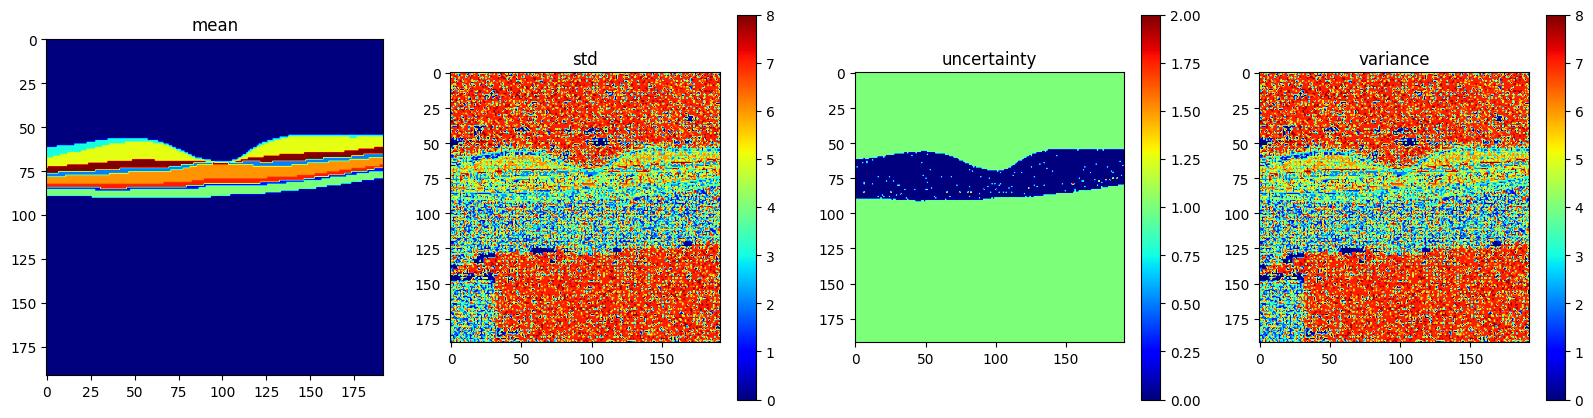

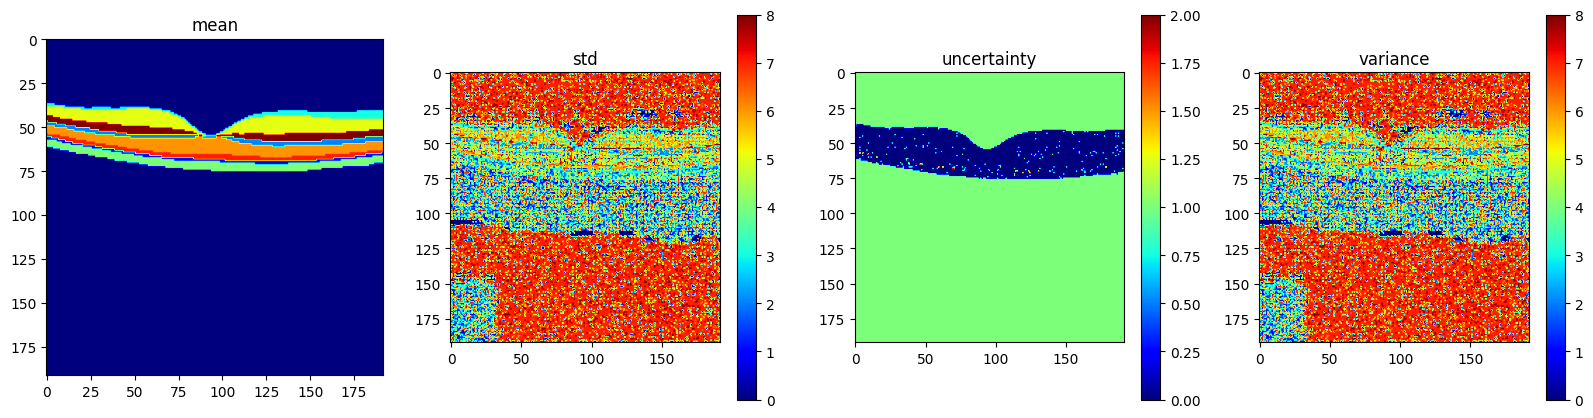

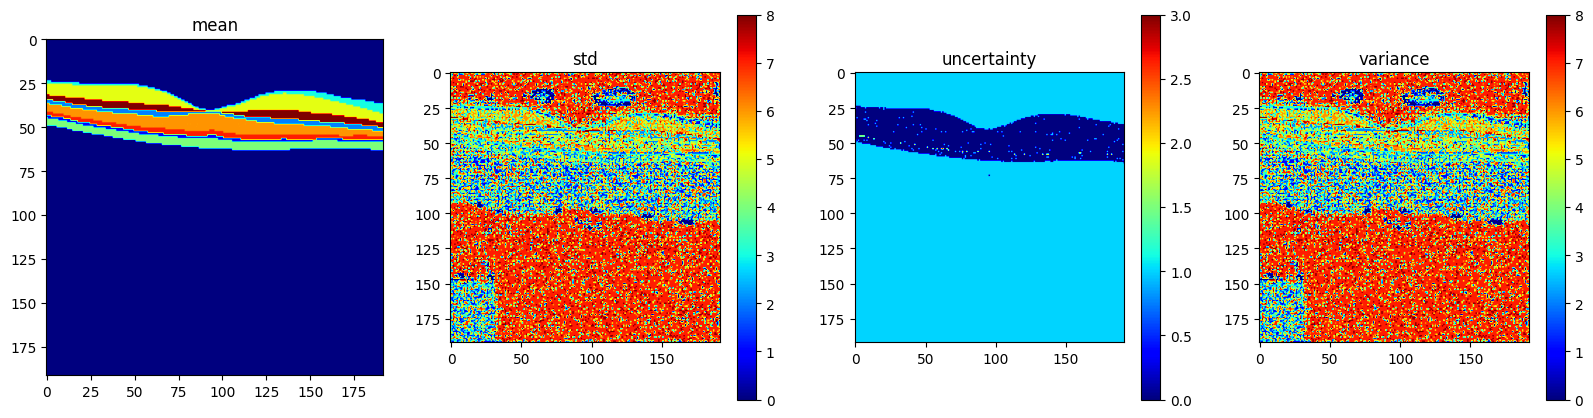

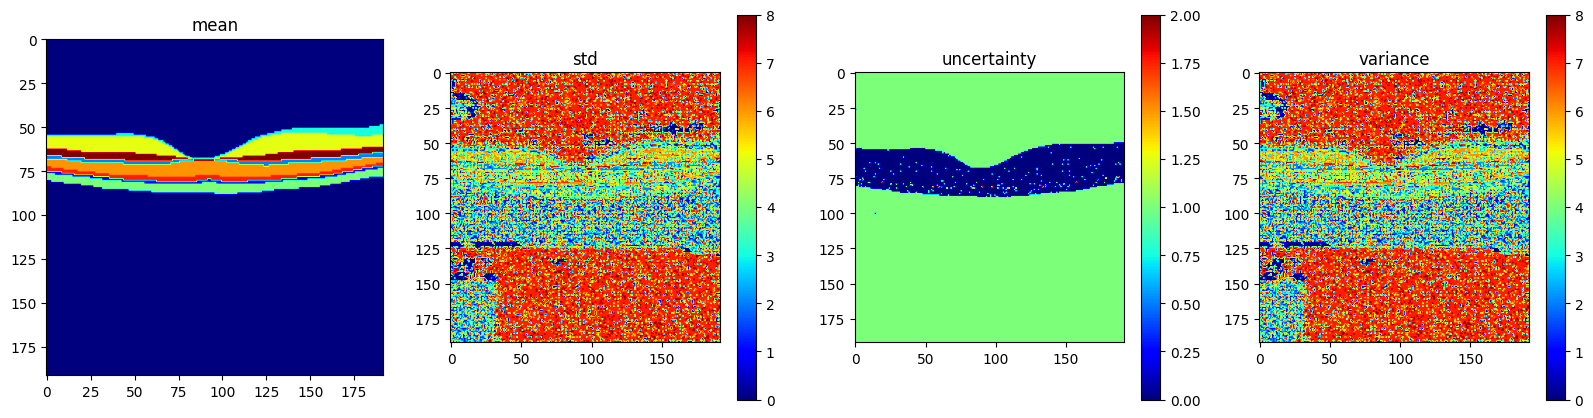

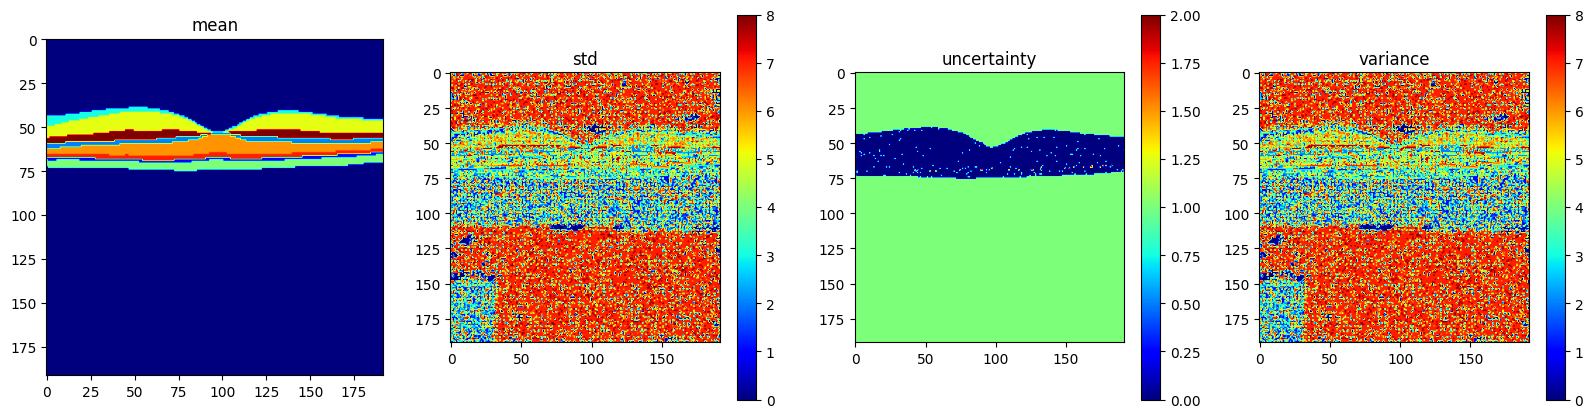

In [51]:
for i in range(5):
    plt.figure(figsize=(20, 5))

    plt.subplot(1,4,1)
    plt.imshow(preds_mean[i],cmap="jet")
    plt.title("mean")
#     plt.colorbar()

    plt.subplot(1,4,2)
    plt.imshow(preds_std[i],cmap="jet")
    plt.title("std")
    plt.colorbar()

    plt.subplot(1,4,3)
    plt.imshow(uncertain[i],cmap="jet")
    plt.title("uncertainty")
    plt.colorbar()

    plt.subplot(1,4,4)
    plt.imshow(preds_var[i],cmap="jet")
    plt.title("variance")
    plt.colorbar()

    plt.show()

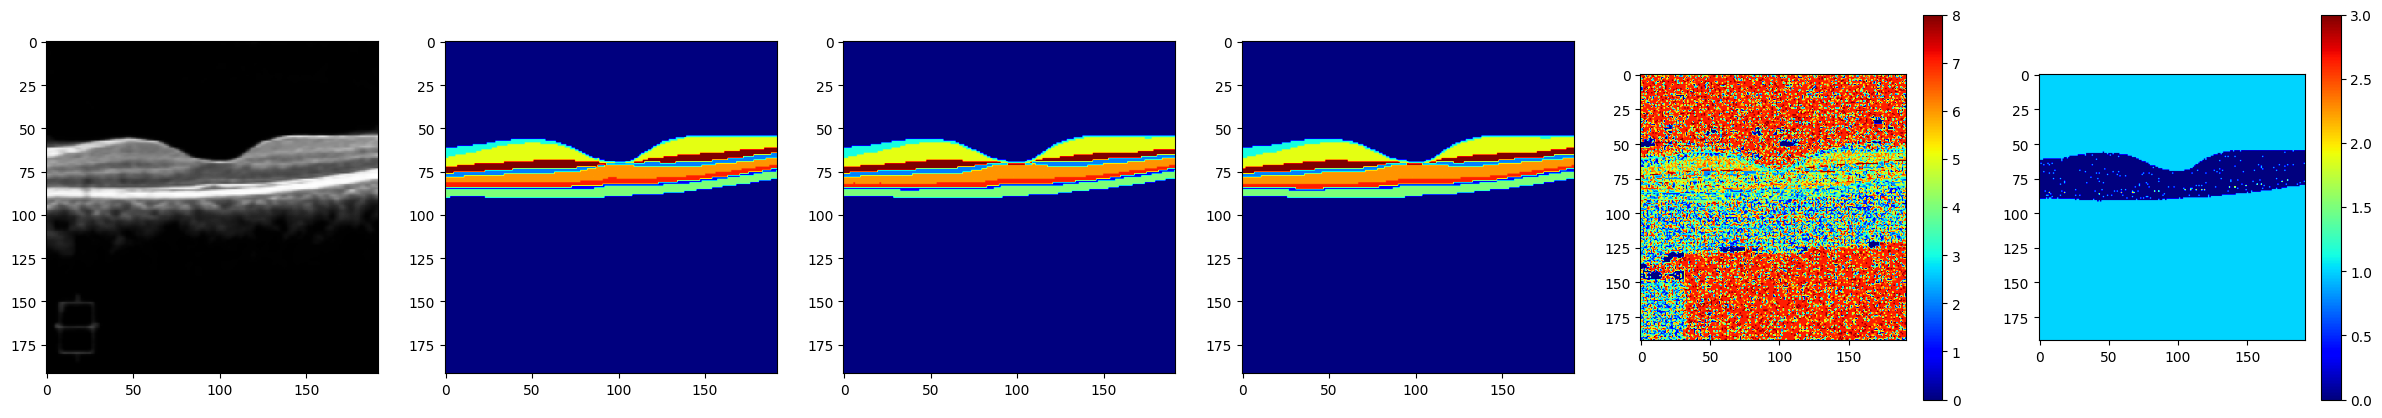

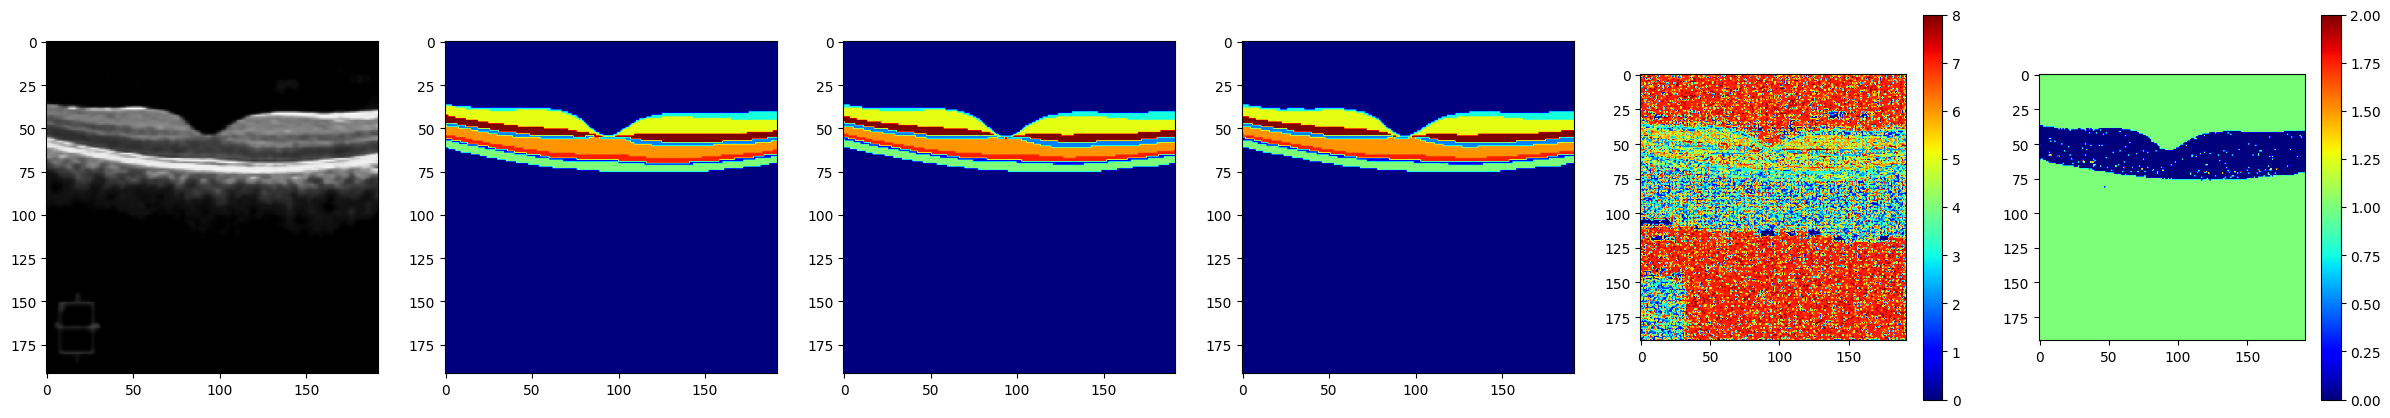

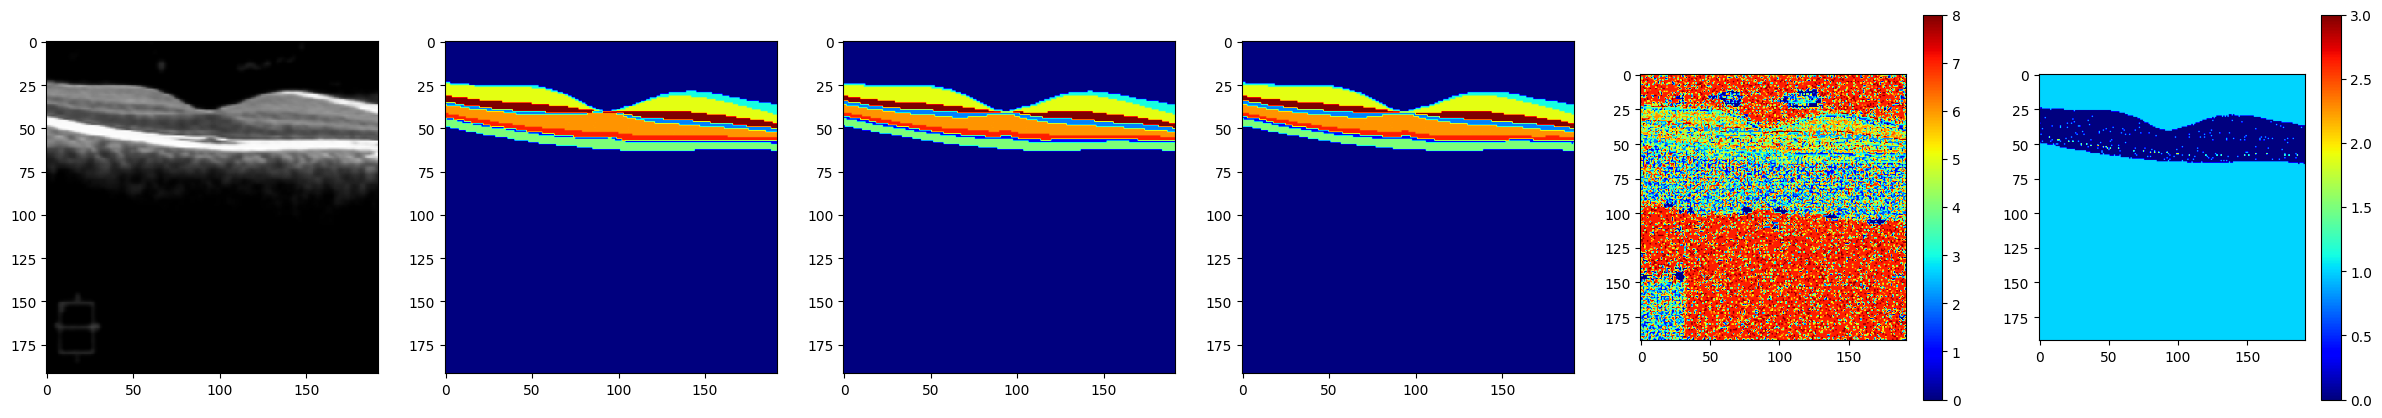

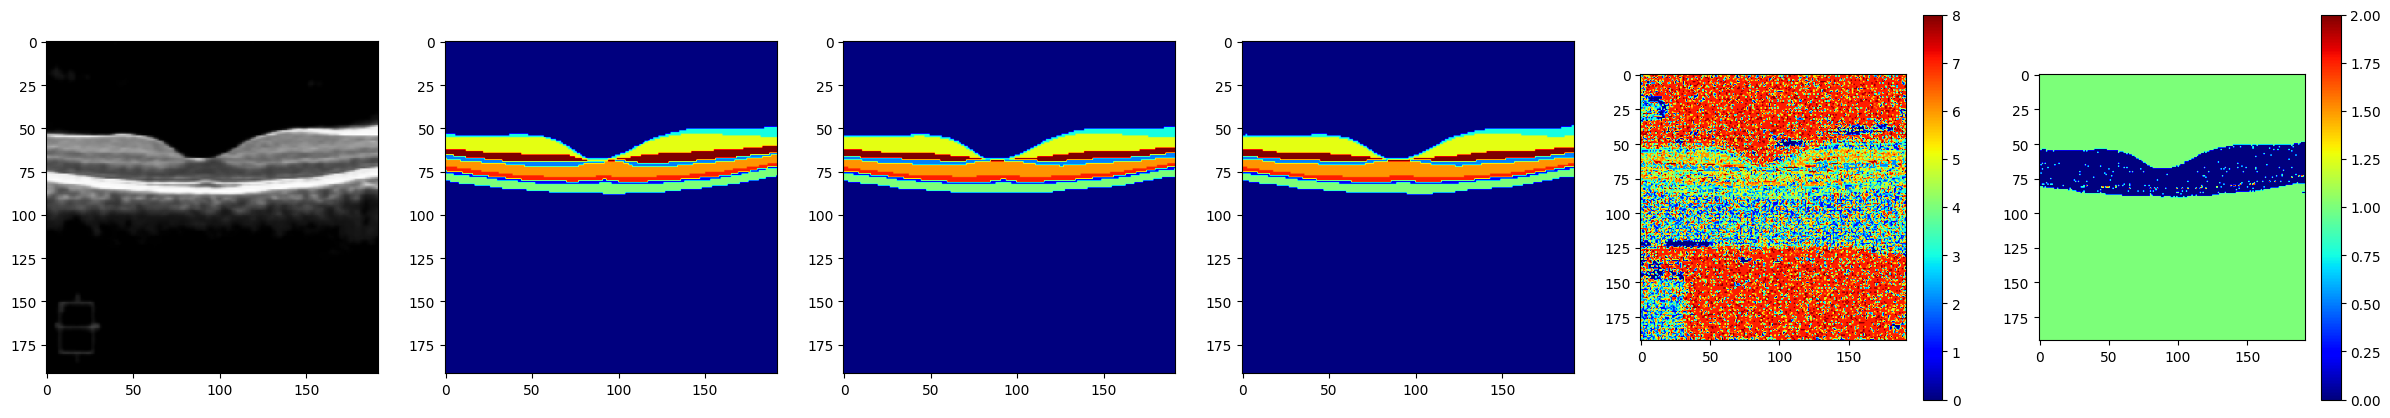

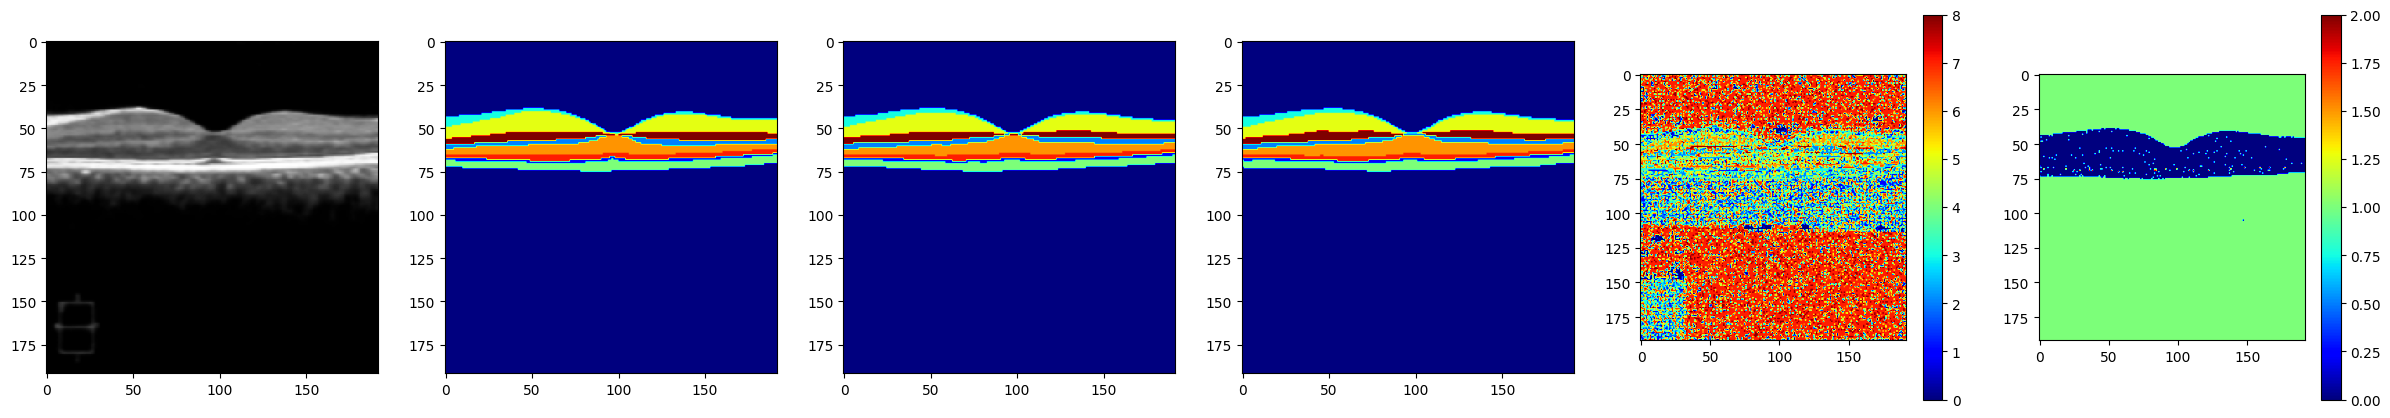

In [38]:
for i, (img, org, msk, mean, std, uc) in enumerate(zip(imgs, original, pred, preds_mean, preds_std, uncertain)):
    plt.figure(figsize=(30, 5))
    plt.subplot(1,6,1)
    plt.imshow(img, cmap="gray")
    plt.subplot(1,6,2)
    plt.imshow(org,cmap="jet")
    plt.subplot(1,6,3)
    plt.imshow(msk,cmap="jet")
    plt.subplot(1,6,4)
    plt.imshow(mean,cmap="jet")
    plt.subplot(1,6,5)
    plt.imshow(std, cmap="jet")
    plt.colorbar()
    plt.subplot(1,6,6)
    plt.imshow(uc, cmap="jet")
    plt.colorbar()
    plt.show()
    if i==4:
        break

In [ ]:
os.makedirs("x_img", exist_ok=True)
os.makedirs("y_img", exist_ok=True)
os.makedirs("y_pred_img", exist_ok=True)
i=0
for img, org, msk in zip(imgs, original, pred):
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.savefig("x_img/"+str(i)+".png")
    plt.clf()
    plt.imshow(org,cmap="jet")
    plt.savefig("y_img/"+str(i)+".png")
    plt.clf()
    plt.imshow(msk,cmap="jet")
    plt.savefig("y_pred_img/"+str(i)+".png")
    plt.clf()
    i+=1